# 1D Heat equation; MLP

In [27]:
# initial plot
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import pandas as pd
from torch.utils.tensorboard import SummaryWriter

We will store the temperature u, at a given x,t in a 2D tensor called U(t,x)

In [28]:
# setup time-space geometry
num_points = 51
x_start = 0
x_stop = 1
num_timesteps = 1000
t_start = 0
t_stop = 1 

# 2D array to hold U(x,t)
x = np.linspace(start=x_start, stop=x_stop, num=num_points)
t = np.linspace(start=t_start, stop=t_stop, num=num_timesteps)
U = np.zeros((t.shape[0],x.shape[0]))
print(U.shape)

#Thermal diffusivity
alpha = 1.22e-3

#Numerical stability constraints
dx = x[1] - x[0] 
dt = 0.5 * dx**2 / alpha
sigma = alpha * dt / dx**2

#Intital conditions at t=0
U[0][:] = np.sin(np.pi * x)

# plot factor
plot_factor = int(np.floor(num_timesteps / 5))

(1000, 51)


In [29]:
def delta_heat(u):
    sigma = alpha * dt / dx**2
    return (sigma * (u[2:] - 2*u[1:-1] + u[:-2]))

plotting at timestep 0
plotting at timestep 200
plotting at timestep 400
plotting at timestep 600
plotting at timestep 800


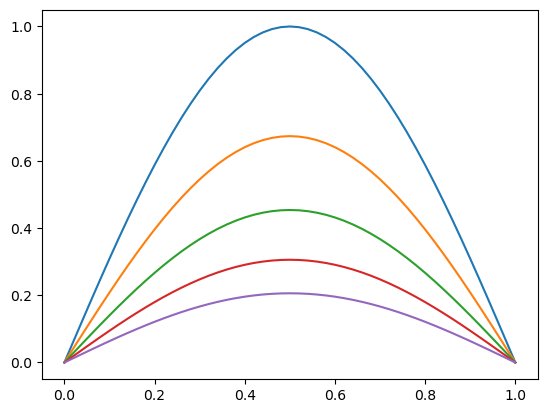

In [30]:
# evolve the heat over all timesteps
for tstep in range(len(t)):
    if tstep == 0:
        print(f"plotting at timestep 0")
        plt.plot(x,U[tstep][:])
        continue
    U[tstep][1:-1] = U[tstep-1][1:-1] + delta_heat(U[tstep-1][:])
    if tstep % plot_factor == 0:
        print(f"plotting at timestep {tstep}")
        plt.plot(x,U[tstep][:])

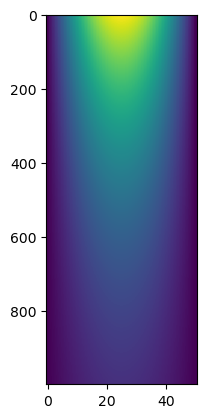

In [31]:
#Plot 2D heat diffusion using imshow
# - x axis is space
# - y axis is time
plt.imshow(U, aspect=0.125)

In [32]:
#Save numpy array to file to avoid having to recreate it every time
#Not a big deal here but will help when we extend to larger problem sizes
np.save("./1d-heat",U)

## Classic MLP Neural Network to learn the 1D-heat diffusion equation

The goal of the following section is to show the failure of MLP with no physics constraints

Prepare data for model tranining by extend the Dataset class to use our custom data \
Following this tutorial: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

- Use Dataset to store the samples and their corresponding labels
- DataLoader wraps an iterable around the Dataset to enable easy access to the samples

In [33]:
U_load = np.load("./1d-heat.npy")

In [34]:
features = np.ones((U_load.shape[0]*U_load.shape[1],2))
features[:,1] = np.tile(x,U_load.shape[0])
features[:,0] = np.repeat(t,U_load.shape[1])
print(features[0:5])
print(features[-5:])

[[0.   0.  ]
 [0.   0.02]
 [0.   0.04]
 [0.   0.06]
 [0.   0.08]]
[[1.   0.92]
 [1.   0.94]
 [1.   0.96]
 [1.   0.98]
 [1.   1.  ]]


In [35]:
labels = np.ones((U_load.shape[0]*U_load.shape[1],1))
labels = U_load.ravel()
labels[0:5]

array([0.        , 0.06279052, 0.12533323, 0.18738131, 0.24868989])

In [36]:
features = features.astype(np.float32)
labels = labels.astype(np.float32)

At this point we have got our data from a saved file into two tensors.
A 1-D tensor of output temperatures and a 2D tensor of space (x) and time (t) input values.

Now we need to seperate training data from testing data. \
What else needs to happen....scale it? Cross-validation? How do these techniques fit into DNN?
Possivly use normalize as a transform that gets pased to the dataset class

In this next section I need to take the output from above and get it into a Dataset/DataLoader format to be used by the model

In [37]:
#Define dataset to use with dataloader
class HeatDataset(torch.utils.data.Dataset):
    def __init__(self, features, labels, transform=None):
        self.features = features
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        x = self.features[idx]
        y = self.labels[idx]

        if self.transform:
            x = self.transform(x)
            y = self.transform(y)

        return x, y

In [38]:
# Define MLP model architecture class
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = torch.nn.Flatten()
        self.linear_relu_stack = torch.nn.Sequential(
            torch.nn.Linear(2, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 1)
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.linear_relu_stack(x)
    
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)

        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            #print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [39]:
writer = SummaryWriter('runs/exp1')

model = NeuralNetwork()

dataset = HeatDataset(features, labels)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True, num_workers=0)

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(data_loader, model, loss_fn, optimizer)
print("Done!")

Epoch 1
-------------------------------


/Users/harry/miniconda3/envs/pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/harry/miniconda3/envs/pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([56])) that is different to the input size (torch.Size([56, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 2
-------------------------------
Epoch 3
-------------------------------
Epoch 4
-------------------------------
Epoch 5
-------------------------------
Epoch 6
-------------------------------
Epoch 7
-------------------------------
Epoch 8
-------------------------------
Epoch 9
-------------------------------
Epoch 10
-------------------------------
Done!


In [40]:
# Do inference
with torch.inference_mode():
    prediction = model(torch.Tensor(features))

prediction.shape

torch.Size([51000, 1])

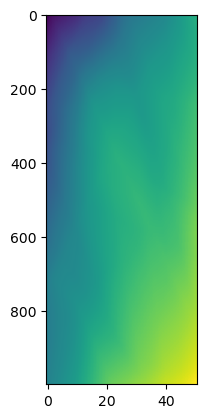

In [41]:
# Plot the simulation, predicted and residual with subplots
# Create a figure with 3 subplots, 0=real, 1=prediction, 2=residual
# Add a legend
# Add x axis and y axis labels
# Add subplot title
plt.imshow(prediction.reshape_as(torch.Tensor(U)), aspect=0.125)

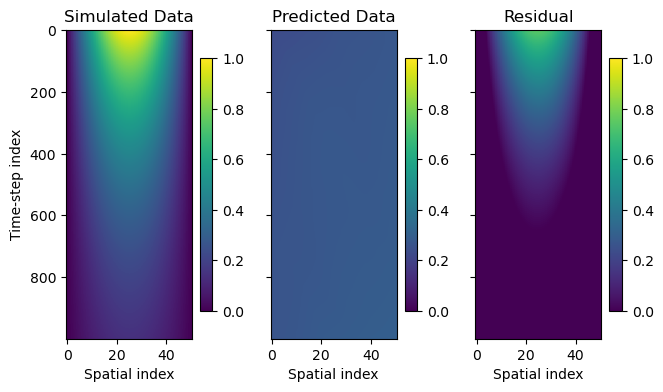

In [68]:
def result_plot(simulation, prediction):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
    f.tight_layout()

    #Min and max of real data
    sim_min = np.min(simulation)
    sim_max = np.max(simulation)
    
    sim_im = ax1.imshow(simulation, aspect=0.125, vmin=sim_min, vmax=sim_max)
    pred_im = ax2.imshow(prediction, aspect=0.125, vmin=sim_min, vmax=sim_max)
    res_im = ax3.imshow(simulation-np.asarray(prediction), aspect=0.125, vmin=sim_min, vmax=sim_max)

    #Really I want them to share the same colorbar
    f.colorbar(sim_im, orientation='vertical', shrink=0.6)
    f.colorbar(pred_im, orientation='vertical', shrink=0.6)
    f.colorbar(res_im, orientation='vertical', shrink=0.6)  
    
    #Titles and labels
    ax1.set_title("Simulated Data")
    ax1.set_ylabel("Time-step index")
    ax1.set_xlabel("Spatial index")
    ax2.set_title("Predicted Data")
    ax2.set_xlabel("Spatial index")
    ax3.set_title("Residual")
    ax3.set_xlabel("Spatial index")
    
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)



prediction = prediction.reshape_as(torch.Tensor(U))
simulation = U
result_plot(simulation,prediction)

In [42]:
# Add TensorBoard support
# Need to sort out how to get color images into tensorboard - this is greyscale
# Possibly this would do it... https://stackoverflow.com/questions/49271913/convert-numpy-array-to-rgb-image
img = torch.reshape(prediction, (1, U.shape[0], U.shape[1]))
img.shape
writer.add_image('img', img)